In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_stereo import AxesAnaglyph

img1 = cv2.imread("./000006-color.jpg", cv2.IMREAD_COLOR)
img2 = cv2.imread("./000007-color.jpg", cv2.IMREAD_COLOR)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

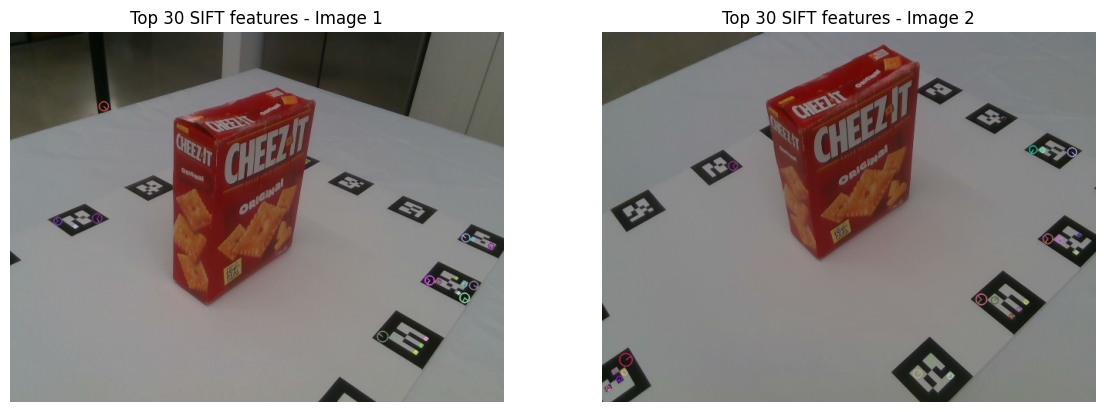

In [4]:
# Initiate SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# find the keypoints and descriptors with SIFT
img1_kp = cv2.drawKeypoints(img1, sorted(kp1, key=lambda x: -x.response)[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, sorted(kp2, key=lambda x: -x.response)[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.title('Top 30 SIFT features - Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.title('Top 30 SIFT features - Image 2')
plt.axis('off')
plt.show()

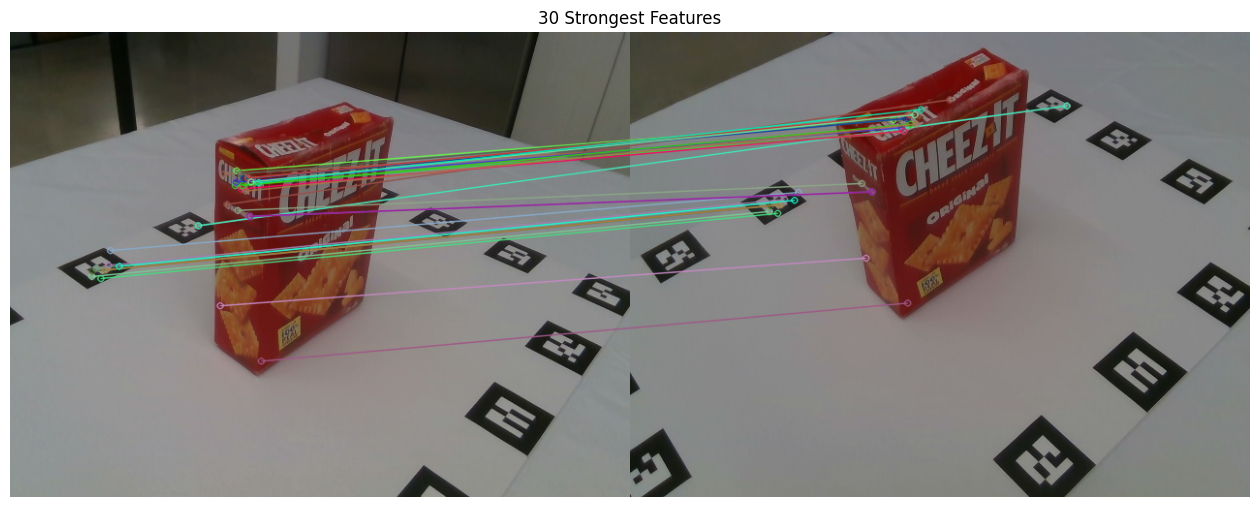

In [21]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title('30 Strongest Features')
plt.axis('off')
plt.show()

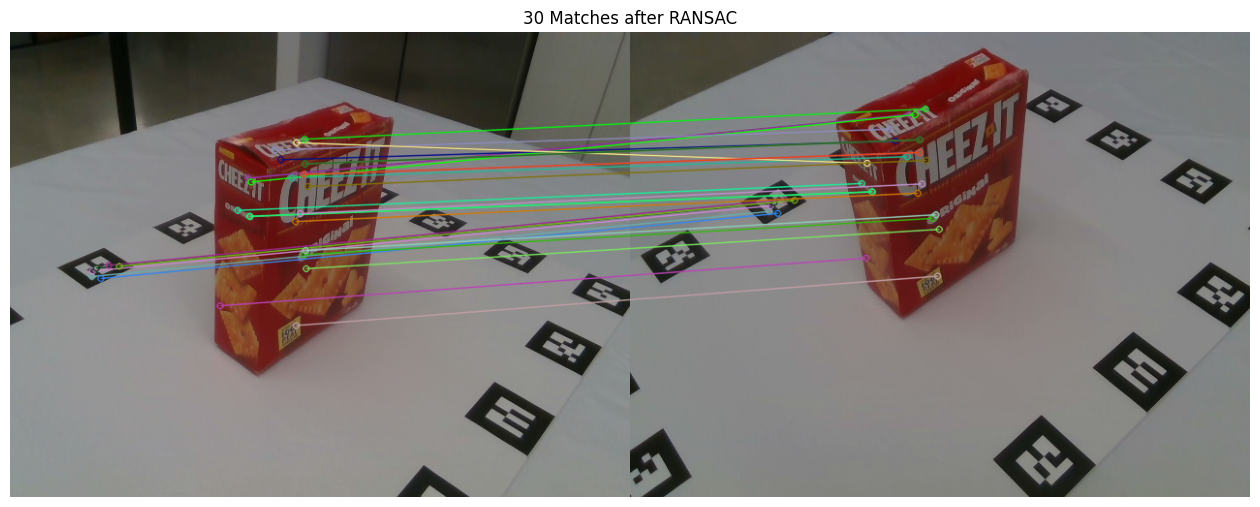

In [22]:
# Step 2: Compute the fundamental matrix using RANSAC
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute the fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Remove outliers
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

inlier_img = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(inlier_img, cv2.COLOR_BGR2RGB))
plt.title('30 Matches after RANSAC')
plt.axis('off')
plt.show()

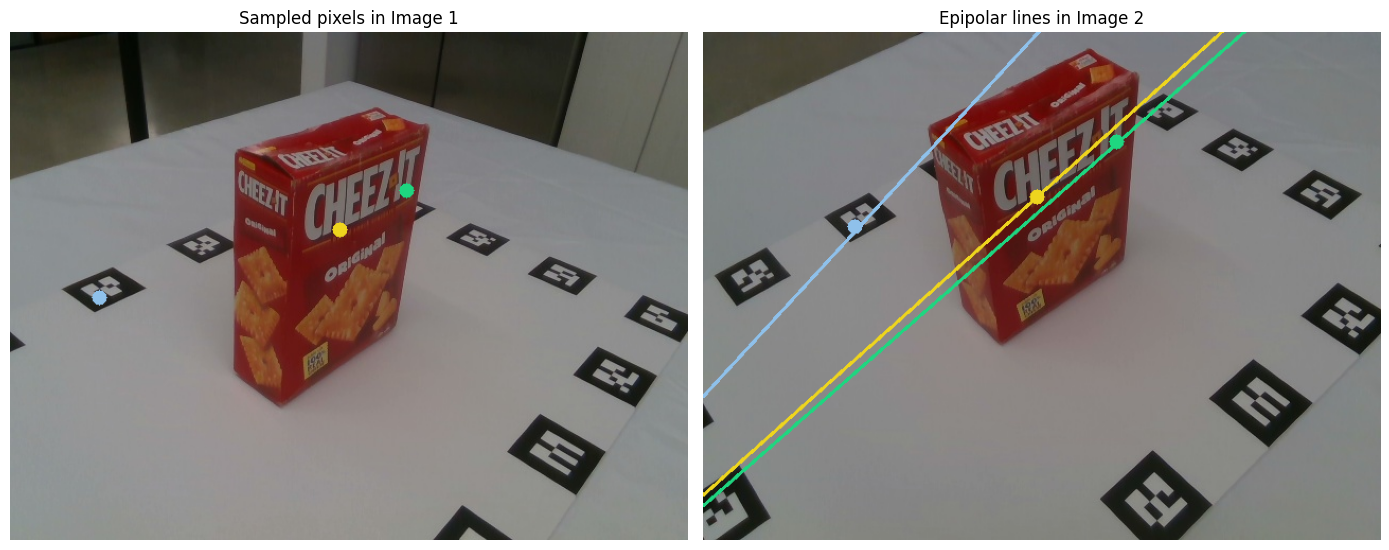

In [26]:
# Step 3: Draw epipolar lines
pts1_inliers = np.float32([kp1[m.queryIdx].pt for m in inlier_matches])
pts2_inliers = np.float32([kp2[m.trainIdx].pt for m in inlier_matches])
colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(3)]
def draw_points(img, pts):
    img_out = img.copy()
    for pt, color in zip(pts, colors):
        cv2.circle(img_out, tuple(np.int32(pt)), 7, color, -1)
    return img_out

def draw_epipolar_lines(img, lines, pts):
    img_out = img.copy()
    h, w = img.shape[:2]
    for r, pt, color in zip(lines, pts, colors):
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [w, -(r[2] + r[0] * w) / r[1]])
        cv2.line(img_out, (x0, y0), (x1, y1), color, 2)
        cv2.circle(img_out, tuple(np.int32(pt)), 7, color, -1)
    return img_out

indices = [0, len(pts1_inliers)//3, 2*len(pts1_inliers)//3]
sample_pts1 = pts1_inliers[indices]
sample_pts2 = pts2_inliers[indices]
sample_pts1_hom = np.hstack([sample_pts1, np.ones((3, 1))])
epilines2 = (F @ sample_pts1_hom.T).T

img1_marked = draw_points(img1, sample_pts1)
img2_epilines = draw_epipolar_lines(img2, epilines2, sample_pts2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_marked, cv2.COLOR_BGR2RGB))
plt.title("Sampled pixels in Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_epilines, cv2.COLOR_BGR2RGB))
plt.title("Epipolar lines in Image 2")
plt.axis('off')
plt.tight_layout()
plt.show()

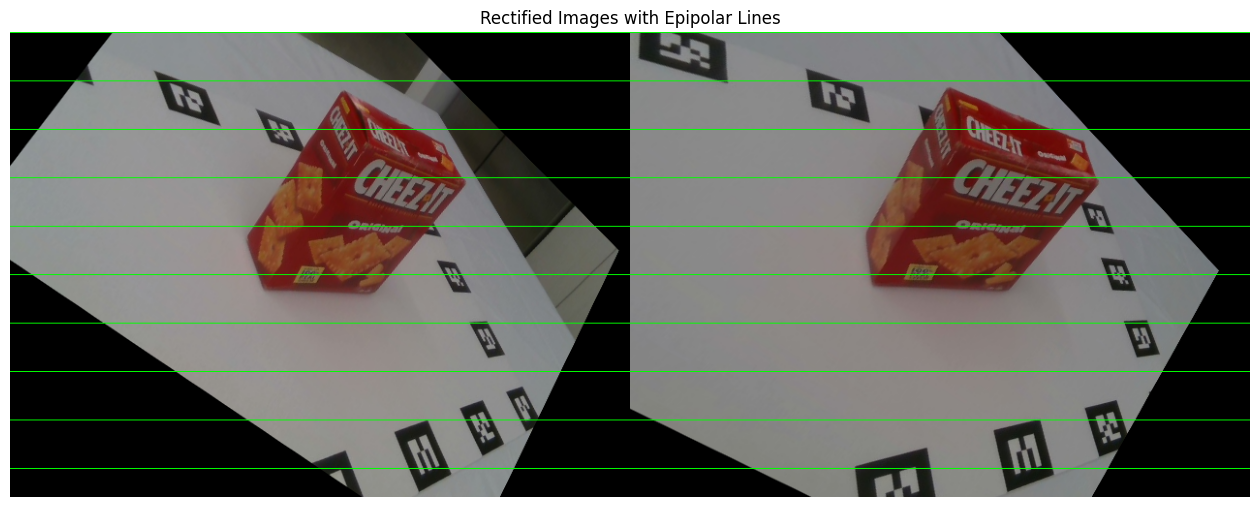

In [27]:
# Step 4.1: Compute Rectification Homographies
h1, w1 = img1.shape[:2]
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    pts1_inliers, pts2_inliers, F, imgSize=(w1, h1)
)

# Step 4.2: Apply the Homographies
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w1, h1))

def show_rectified(imgL, imgR):
    canvas = np.hstack((imgL, imgR))
    for y in range(0, canvas.shape[0], 50):
        cv2.line(canvas, (0, y), (canvas.shape[1], y), (0, 255, 0), 1)
    return canvas

rectified_pair = show_rectified(img1_rectified, img2_rectified)
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(rectified_pair, cv2.COLOR_BGR2RGB))
plt.title("Rectified Images with Epipolar Lines")
plt.axis('off')
plt.show()

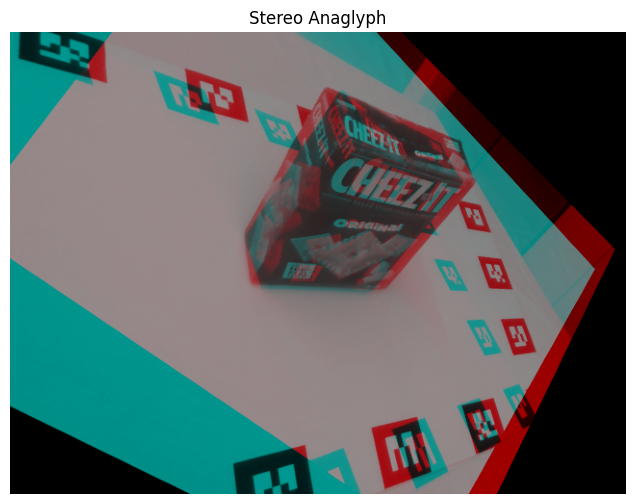

In [34]:
grayL = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(10, 6))
stereo_ax = AxesAnaglyph(fig)

stereo_ax.imshow_stereo(grayL, grayR)
plt.title("Stereo Anaglyph")
plt.axis('off')
plt.show()